In [1]:
#Imports
import sys
sys.path.append('../python/')
#import NGC5533_functions-newmag as nf

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import lmfit as lm
import dataPython as dp
import scipy.interpolate as inter

import NGC5533_functions_newmag as nf
#import noordermeer as noord

from datetime import datetime
import time

If you do, DISCARD ALL CHANGES TO THE FILE.
Your calculations will NOT be consistent with this library's equations if you use the disk.hdf5 or bulge.hdf5 files,
and if you write to that file it will contain calculations based on conflicting constants.
Worst case scenario, reset the disk.hdf5 file to before the commit where you used this library to write to it.


In [2]:
#import data files:
starttime = time.time()

#TRACING:**************************************
#data points:
data = dp.getXYdata_wXYerr('../NGC_5005/traced_data/ngc5005_data.txt')
r_dat = np.asarray(data['xx'])
v_dat = np.asarray(data['yy'])
v_err0 = np.asarray(data['ex'])
v_err1 = np.asarray(data['ey'])
#v_err1=v_err1[:len(v_err1)-1]
#r_dat=r_dat[:len(r_dat)-1]
#v_dat=v_dat[:len(v_dat)-1]

#gas rotmod:
gas_rdata = dp.getXYZdata('aygas.dat')
rgasr = gas_rdata['xx']
rgasv = gas_rdata['zz']
rgasv=np.asarray(rgasv)
rgasv_spline = inter.InterpolatedUnivariateSpline(rgasr,rgasv,k=5)
rgasv_fit = rgasv_spline(r_dat)

#make gas array same length as data points array ????? how can I fit without doing this?????
rgasv=rgasv[:len(rgasv)-9]
rgasv=rgasv[0::68]
rgasr=rgasr[:len(rgasr)-9]
rgasr=rgasr[0::68]
rgasv_fit=rgasv

#bulge rotmod:
bulge_rdata = dp.getXYZdata('aybulge.dat')
rbulger = bulge_rdata['xx']
rbulgev = bulge_rdata['zz']
rbulgev=np.asarray(rbulgev)
#rbulger = [x - 1.15 for x in rbulger]
#rbulger=rbulger[:len(rbulger)-5]
#rbulger=rbulger[0::72]
#rbulgev=rbulgev[:len(rbulgev)-5]
#rbulgev=rbulgev[0::72]
rbulgev_spline = inter.InterpolatedUnivariateSpline(rbulger,rbulgev,k=5)
rbulgev_fit = rbulgev_spline(r_dat)
rbulgev_fit=rbulgev

#manually replacing "peak" in bulge to true peak
#not sure if this makes a difference
#rbulger[1] = .58 #.409 from trace
#rbulgev[1]=653.7

#disk rotmod:
disk_rdata = dp.getXYZdata('aydisk.dat')
rdiskr = disk_rdata['xx']
rdiskv = disk_rdata['zz']
rdiskv=np.asarray(rdiskv)
#rdiskv=rdiskv[:len(rdiskv)-5]
#rdiskv=rdiskv[0::72]
rdiskv_spline = inter.InterpolatedUnivariateSpline(rdiskr,rdiskv,k=5)
rdiskv_fit = rdiskv_spline(r_dat)
rdiskv_fit=rdiskv

#Halo datathief trace:
halo_dt = dp.getXYdata('../NGC_5005/datatheif_halo_spline.txt')
halo_dtr = halo_dt['xx']
halo_dtv = halo_dt['yy']
halo_dtv=np.asarray(halo_dtv)
#halo_dtv=halo_dtv[:len(halo_dtv)-5]
#halo_dtv=halo_dtv[0::6]
halo_dtv_spline = inter.InterpolatedUnivariateSpline(halo_dtr,halo_dtv,k=5)
halo_dtv_fit = halo_dtv_spline(r_dat)


rval = np.linspace(0,12,19)
#print(len(rval))
#print(len(rbulgev))
#print(len(rgasv))
#print(len(rdiskv))
print(len(v_dat))
print(len(r_dat))
print(len(rbulgev_fit))
print(len(rdiskv_fit))
print(len(rgasv_fit))
print(len(v_err1))

19
19
19
19
1
19


In [3]:
# Fitting function, just prefactors for all the components
def g(r,GX,BX,DX,rc,rho00):
    return np.sqrt((GX*rgasv_fit)**2 
                   + (BX*rbulgev_fit)**2 
                   + (DX*rdiskv_fit)**2
                   + (nf.h_v(rval,rc,rho00))**2)

In [4]:
v_err1=v_err1
weighdata=1/v_err1
# LMFit

#Setup
g_mod = lm.Model(g)
g_params = g_mod.make_params()
#Gas
g_params.add('GX', value=.98, min=0) #Mass

#Bulge
g_params.add('BX', value=1, min=0)          #Prefactor

#Disk
g_params.add('DX', value=1, min=0)       #Prefactor
#Halo
g_params.add('rc', value=1, min=0)          #Core radius (kpc)
g_params.add('rho00', value=1e+08, min=0)     #Central density 

#Do fit
g_fit = g_mod.fit(v_dat,g_params,r=r_dat,weights=weighdata)

In [5]:
# Define for plotting
bestg = g_fit.best_fit
#delg = g_fit.eval_uncertainty()
print('Fit information for all-component fit:')
g_fit

Fit information for all-component fit:


In [6]:
#smoothing --> creating a spline
#print(bestg)

rval = np.arange(0,15,0.1)


#for total fit curve
#r_dat = r_dat[r_dat.argsort()]
r_dat_andzero = np.append([0],r_dat)
idx = np.arange(0,np.shape(r_dat_andzero)[0])

bestg = bestg[r_dat.argsort()]
#f_v_T = inter.InterpolatedUnivariateSpline(r_dat_andzero[idx%1==0], np.append([0],bestg)[idx%1==0], k=3)
#f_v_T_v = np.vectorize(f_v_T)

"""
#for gas:
rgasv = rgasv[rval.argsort()]
f_v_G = inter.InterpolatedUnivariateSpline(rval[idx%1==0], rgasv[idx%1==0], k=5)
f_v_G_v = np.vectorize(f_v_G)

#for disk:
rdiskv = rdiskv[rval.argsort()]
f_v_D = inter.InterpolatedUnivariateSpline(rval[idx%1==0], rdiskv[idx%1==0], k=5)
f_v_D_v = np.vectorize(f_v_D)

#for halo:
halo_dtv = halo_dtv[rval.argsort()]
f_v_H = inter.InterpolatedUnivariateSpline(rval[idx%1==0], halo_dtv[idx%1==0], k=5)
f_v_H_v = np.vectorize(f_v_H)

#for bulge:
rbulgev = rbulgev[rval.argsort()]
f_v_B = inter.InterpolatedUnivariateSpline(rval[idx%1==0], rbulgev[idx%1==0], k=5)
f_v_B_v = np.vectorize(f_v_B)
"""

'\n#for gas:\nrgasv = rgasv[rval.argsort()]\nf_v_G = inter.InterpolatedUnivariateSpline(rval[idx%1==0], rgasv[idx%1==0], k=5)\nf_v_G_v = np.vectorize(f_v_G)\n\n#for disk:\nrdiskv = rdiskv[rval.argsort()]\nf_v_D = inter.InterpolatedUnivariateSpline(rval[idx%1==0], rdiskv[idx%1==0], k=5)\nf_v_D_v = np.vectorize(f_v_D)\n\n#for halo:\nhalo_dtv = halo_dtv[rval.argsort()]\nf_v_H = inter.InterpolatedUnivariateSpline(rval[idx%1==0], halo_dtv[idx%1==0], k=5)\nf_v_H_v = np.vectorize(f_v_H)\n\n#for bulge:\nrbulgev = rbulgev[rval.argsort()]\nf_v_B = inter.InterpolatedUnivariateSpline(rval[idx%1==0], rbulgev[idx%1==0], k=5)\nf_v_B_v = np.vectorize(f_v_B)\n'

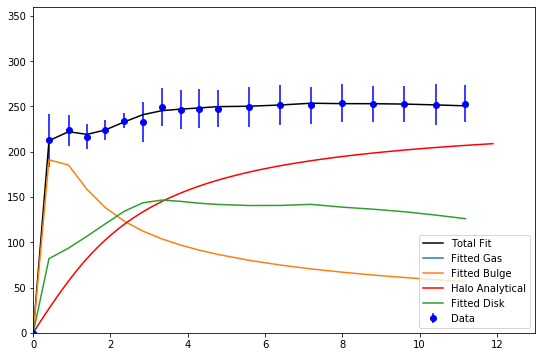

In [7]:
# Define for plotting cont.

rval = np.arange(0,12,0.1)


g_dict = g_fit.best_values
g_g = g_dict['GX']
g_b = g_dict['BX']
g_d = g_dict['DX']
g_rc = g_dict['rc']
g_rho00 = g_dict['rho00']
halo_curve = nf.h_v(rval,g_rc,g_rho00)

plt.figure(figsize=(9,6))
plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
#plt.plot(rval,f_v_T_v(rval),'k',label='Total Fit')
plt.plot(r_dat,bestg,'k',label='Total Fit')
plt.plot(rgasr,g_g*rgasv,label='Fitted Gas')


plt.plot(rbulger,g_b*rbulgev,label='Fitted Bulge')
#plt.scatter(r_dat,g_b*rbulgev_spline(r_dat),label='Bulge Points') #confusion
plt.plot(rval,halo_curve,'r-',label='Halo Analytical')

halo_curve=halo_curve[:len(halo_curve)-6]
halo_curve=halo_curve[0::6]

plt.plot(rdiskr,g_d*rdiskv,label='Fitted Disk')
#plt.plot(halo_dtr,g_h*halo_dtv,label='Fitted Halo')
#ZZZ=np.append([0],bestg)
#bary=ZZZ-halo_curve
#plt.plot(r_dat_andzero,bary,'m',label='Baryonic (visible) matter')

plt.legend(loc='lower right')
plt.ylim(0,360)
plt.xlim(0,13)
plt.show()